## Goal:

Here we test the functions: `lbfgsb` in the `Screenkhorn` class.

In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 


# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn


## Data generation

In [2]:
n_1 = 15000# nb samples
n_2 = 15000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.7

K = np.exp(-M/reg)

## Sinkhorn 

In [3]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
print("time of Sinkhorn algorithm is %s" %time_sink)

time of Sinkhorn algorithm is 18.53338313102722


## Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$


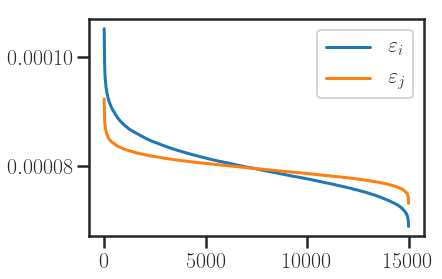

In [4]:
epsilons_a = np.sqrt(a / K.sum(axis=1))
epsilons_a_sort = np.sort(epsilons_a)[::-1]
epsilons_b = np.sqrt(b / K.T.sum(axis=1))
epsilons_b_sort = np.sort(epsilons_b)[::-1]
plt.plot(epsilons_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilons_b_sort, label=r'$\varepsilon_j$')
plt.legend();

#### Choice of epsilon

In [5]:
epsilons_ab = np.sort(np.hstack([epsilons_a, epsilons_b]))[::-1]
epsilon_mid = (max(epsilons_ab) - min(epsilons_ab))/3 + min(epsilons_ab)
epsilon_min = min(epsilons_ab)
epsilon_max = max(epsilons_ab)

epsilon_min, epsilon_mid, epsilon_max

(6.879087702215872e-05, 8.093689070512004e-05, 0.00010522891807104267)

#### Initial points and a priori active sets

In [6]:
u0 = np.full(n_1, epsilon_min)
v0 = np.full(n_2, epsilon_min)

I_active = np.where(a >= epsilon_min**2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= epsilon_min**2 * K.T.sum(axis=1))[0].tolist()

u0[I_active] = epsilon_min
v0[J_active] = epsilon_min

In [7]:
## Cardinals of I_active and J_active
len(I_active), len(J_active)

(14999, 15000)

In [8]:
## Initialize Screenkhorn class
screenkhorn = Screenkhorn(a, b, M, reg, epsilon_min)

## L-BFGS-B

In [9]:
# res_sink = screenkhorn.restricted_sinkhorn(u0, v0, I_active, J_active, max_iter=1000, tol=1e-9)
# u0 = res_sink['usc']
# v0 = res_sink['vsc']
tic = time()
lbfgsb = screenkhorn.lbfgsb(u0, v0, I_active, J_active)
toc_bfgs = time() - tic
toc_bfgs

Certificate is achieved
Time spending during the restricted Skinkhorn is 21.26534605026245


64.59365177154541

In [10]:
time_sink, toc_bfgs, toc_bfgs / time_sink

(18.53338313102722, 64.59365177154541, 3.485259615844637)

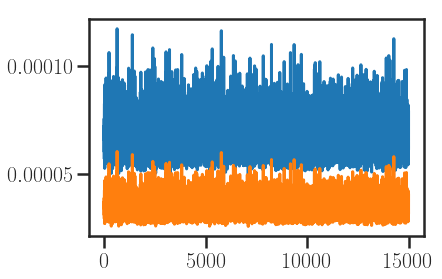

In [11]:
plt.plot(exp_u_star)
plt.plot(lbfgsb[0]/2)

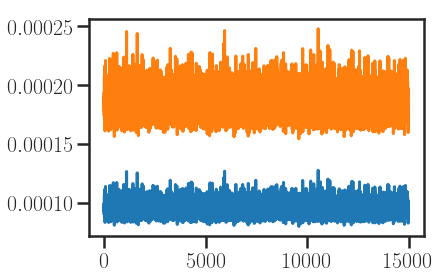

In [12]:
plt.plot(exp_v_star)
plt.plot(lbfgsb[1]*2)

In [13]:
# sinkhorn
P_star = np.diag(exp_u_star) @ K @ np.diag(exp_v_star)
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

# screenkhorn via lbfgsb
usc_bfgs = lbfgsb[0]
vsc_bfgs = lbfgsb[1]
P_sc_bfgs = np.diag(usc_bfgs) @ K @ np.diag(vsc_bfgs)
a_sc_bfgs = P_sc_bfgs @ np.ones(n_2)
b_sc_bfgs = P_sc_bfgs.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_bfgs), sum(b_sc_bfgs)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_bfgs)), abs(1 - sum(b_sc_bfgs))))
print("\t")
print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(P_star - P_sc_bfgs,'fro'))
print('\t')
print("Max norm of difference solution matrices %s "  %abs(P_star - P_sc_bfgs).max())

sum of the marginals in sinkhorn are: 0.9999999999999095, 	 1.0000000000000002
	
sum of the marginals in screenkhorn are: 1.000001381416585, 	 1.0000013814165878
	
Difference in sinkhorn: 9.048317650695026e-14 	 2.220446049250313e-16:
	
Difference in screenkhorn: 1.381416584900208e-06 	  1.3814165877867879e-06:
	
Frobenius norm of difference solution matrices 1.960106055919686e-07 
	
Max norm of difference solution matrices 1.7197833003614492e-09 


### Time for greenkhorn

In [14]:
tic = time()
P = greenkhorn(a, b, M, reg, numItermax=100000, stopThr=1e-9, log=False)
P
time_green = time() - tic
time_green, time_sink

(53.799474000930786, 18.53338313102722)

In [15]:
X = np.random.normal(size=(5,8))
X

array([[ 0.75745977, -0.47348854,  0.43188404, -0.89721701,  0.3666067 ,
         0.63093822,  1.36051386,  2.03444845],
       [ 0.22825735,  0.19380404, -0.37902523,  0.66494108,  0.51234401,
         0.12954006, -1.00436707,  0.3325181 ],
       [-2.52752476,  0.32788052,  0.20366704, -0.97273158,  0.00658912,
        -0.52227105, -0.99964737,  1.75206514],
       [-0.037696  , -1.15724938, -0.64145603,  0.89136697,  1.75839829,
         0.57340238,  0.44022955, -0.18001121],
       [ 0.45996782,  0.3652566 ,  0.27587123, -1.20646285,  0.36108057,
        -1.69105025, -0.0287886 ,  0.4831383 ]])

In [16]:
X.min()

-2.527524760292827